<a href="https://colab.research.google.com/github/Ajithareddy2027/FMML-LAB-MODULES/blob/main/Module_7_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Module 7 Project: Movie Recommendation Engine

`Module Coordinator: Ganesh Chandan`

In this module, we will try to create a Movie Recommendation System using different unsupervised learning techniques.

In [1]:
# dataset download

# !wget https://files.grouplens.org/datasets/movielens/ml-100k.zip
!wget https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip ml-latest-small.zip

--2025-02-08 15:09:44--  https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  2.41MB/s    in 0.4s    

2025-02-08 15:09:45 (2.41 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


## Clustering based recommendation

In [2]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
import itertools
from sklearn.metrics import silhouette_samples, silhouette_score

In [3]:
# Import the Movies dataset
movies = pd.read_csv('ml-latest-small/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
# Import the ratings dataset
ratings = pd.read_csv('ml-latest-small/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
# Print the number of records and the total number of movies
print('The dataset contains: ', len(ratings), ' ratings of ', len(movies), ' movies.')

The dataset contains:  100836  ratings of  9742  movies.


### Romance versus Science Fiction

We will start by considering a subset of users and discovering what are their favourite genre. We will do this by defining a function that will calculate each user’s average rating for all science fiction and romance movies.

In [6]:
# Function to get the genre ratings
def get_genre_ratings(ratings, movies, genres, column_names):
    genre_ratings = pd.DataFrame()
    for genre in genres:
        genre_movies = movies[movies['genres'].str.contains(genre) ]
        avg_genre_votes_per_user = ratings[ratings['movieId'].isin(genre_movies['movieId'])].loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)

        genre_ratings = pd.concat([genre_ratings, avg_genre_votes_per_user], axis=1)

    genre_ratings.columns = column_names
    return genre_ratings# Calculate the average rating of romance and scifi movies
genre_ratings = get_genre_ratings(ratings, movies, ['Romance', 'Sci-Fi'], ['avg_romance_rating', 'avg_scifi_rating'])
genre_ratings.head()

,avg_romance_rating,avg_scifi_rating
1,4.31,4.22
2,4.50,3.88
3,0.50,4.20
4,3.38,2.83
5,3.09,2.50


In order to have a more delimited subset of people to study, we are going to bias our grouping to only get ratings from those users that like either romance or science fiction movies.

In [7]:
# Function to get the biased dataset
def bias_genre_rating_dataset(genre_ratings, score_limit_1, score_limit_2):
    biased_dataset =    genre_ratings[((genre_ratings['avg_romance_rating'] < score_limit_1 - 0.2) & (genre_ratings['avg_scifi_rating'] > score_limit_2)) | ((genre_ratings['avg_scifi_rating'] < score_limit_1) & (genre_ratings['avg_romance_rating'] > score_limit_2))]
    biased_dataset = pd.concat([biased_dataset[:300], genre_ratings[:2]])
    biased_dataset = pd.DataFrame(biased_dataset.to_records())
    return biased_dataset

# Bias the dataset
biased_dataset = bias_genre_rating_dataset(genre_ratings, 3.2, 2.5)

# Printing the resulting number of records & the head of the dataset
print( "Number of records: ", len(biased_dataset))
biased_dataset.head()

Number of records:  162


,index,avg_romance_rating,avg_scifi_rating
0,3,0.50,4.20
1,4,3.38,2.83
2,5,3.09,2.50
3,7,2.65,3.15
4,9,3.17,3.00


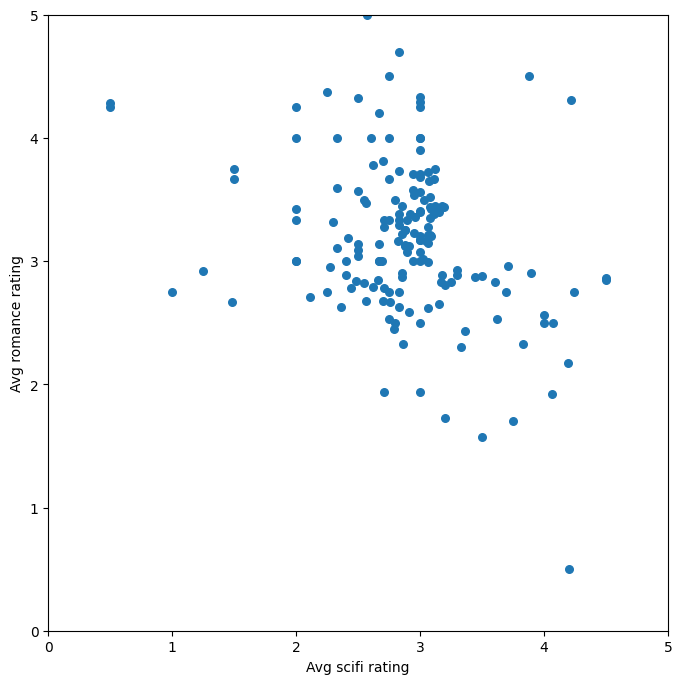

In [8]:
# Defining the scatterplot drawing function
def draw_scatterplot(x_data, x_label, y_data, y_label):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.scatter(x_data, y_data, s=30)

# Plot the scatterplot
draw_scatterplot(biased_dataset['avg_scifi_rating'],'Avg scifi rating', biased_dataset['avg_romance_rating'], 'Avg romance rating')

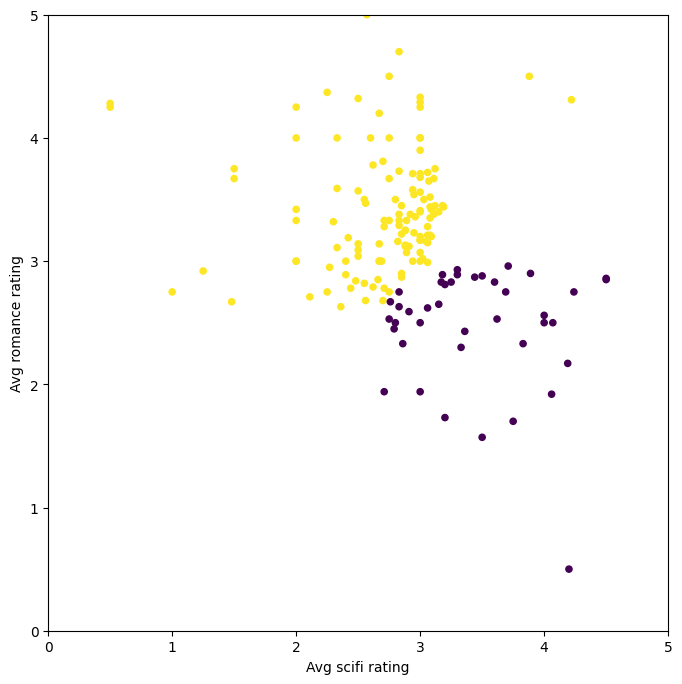

In [9]:
# Let's turn our dataset into a list
X = biased_dataset[['avg_scifi_rating','avg_romance_rating']].values

# Import KMeans
from sklearn.cluster import KMeans

# Create an instance of KMeans to find two clusters
kmeans_1 = KMeans(n_clusters=2)

# Use fit_predict to cluster the dataset
predictions = kmeans_1.fit_predict(X)

# Defining the cluster plotting function
def draw_clusters(biased_dataset, predictions, cmap='viridis'):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg scifi rating')
    ax.set_ylabel('Avg romance rating')
    clustered = pd.concat([biased_dataset.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    plt.scatter(clustered['avg_scifi_rating'], clustered['avg_romance_rating'], c=clustered['group'], s=20, cmap=cmap)

# Plot
draw_clusters(biased_dataset, predictions)

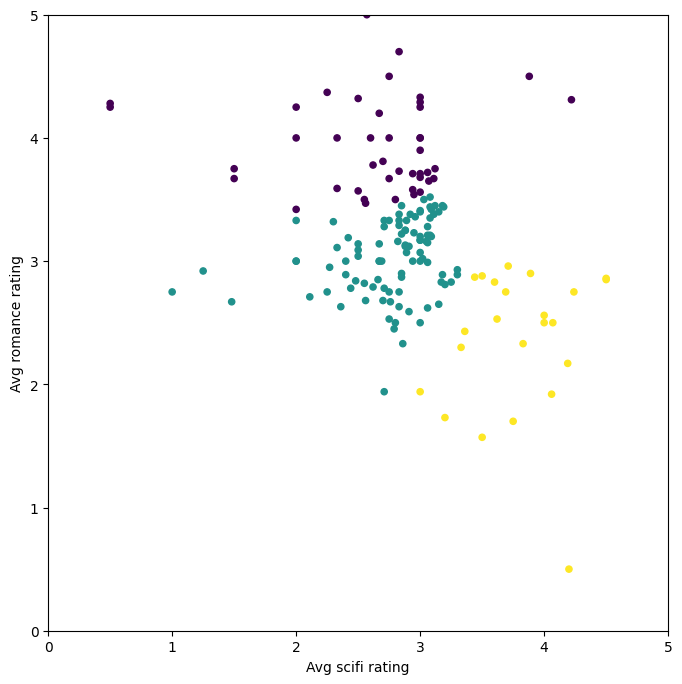

In [10]:
# Create an instance of KMeans to find three clusters
kmeans_2 = KMeans(n_clusters=3)
# Use fit_predict to cluster the dataset
predictions_2 = kmeans_2.fit_predict(X)
# Plot
draw_clusters(biased_dataset, predictions_2)

It is evident now that the science-fiction rating has started to come into play:

    People who like sci-fi and romance modeately belong to the green group.
    People who like scifi but not romance belong to the yello group.
    People who like romance but not sci-fi belong to the purple group.

Finding optimal clusters using silhouette score

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (157) found smaller than n_clusters (162). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


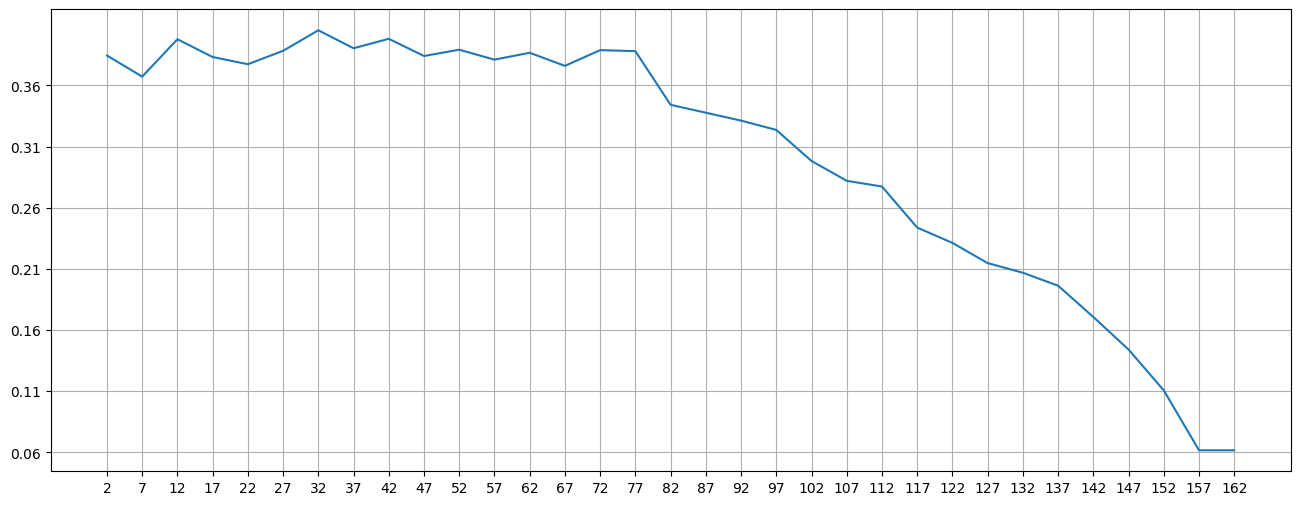

In [11]:
# Selecting our dataset to study
df = biased_dataset[['avg_scifi_rating','avg_romance_rating']]

# Choose the range of k values to test.
# We added a stride of 5 to improve performance. We don't need to calculate the error for every k value
possible_k_values = range(2, len(X)+1, 5)

# Define function to calculate the clustering errors
def clustering_errors(k, data):
    kmeans = KMeans(n_clusters=k).fit(data)
    predictions = kmeans.predict(data)
    #cluster_centers = kmeans.cluster_centers_
    # errors = [mean_squared_error(row, cluster_centers[cluster]) for row, cluster in zip(data.values, predictions)]
    # return sum(errors)
    silhouette_avg = silhouette_score(data, predictions)
    return silhouette_avg

# Calculate error values for all k values we're interested in
errors_per_k = [clustering_errors(k, X) for k in possible_k_values]

# Plot the each value of K vs. the silhouette score at that value
fig, ax = plt.subplots(figsize=(16, 6))
plt.plot(possible_k_values, errors_per_k)

# Ticks and grid
xticks = np.arange(min(possible_k_values), max(possible_k_values)+1, 5.0)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(errors_per_k), 2), max(errors_per_k), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')

We will chose the K = 7 as it is the one that yields the best score and will be easier to visualize.



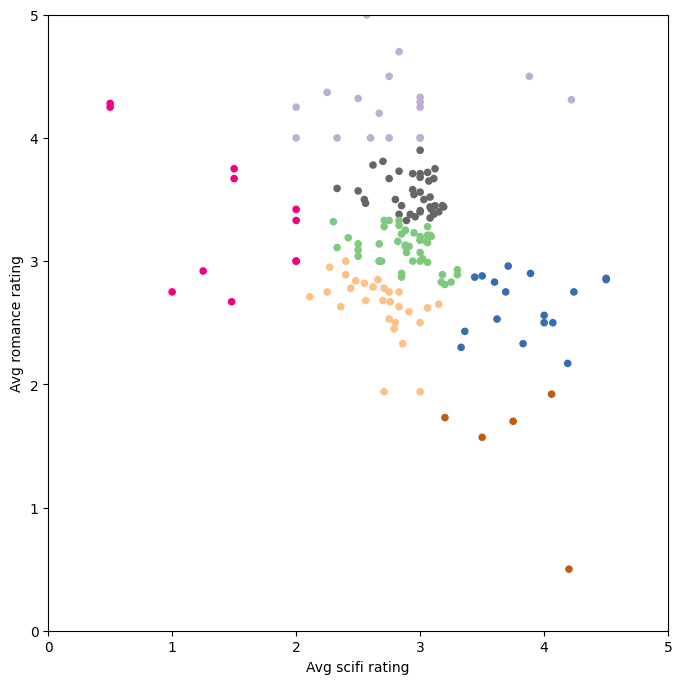

In [12]:
# Create an instance of KMeans to find seven clusters
kmeans_4 = KMeans(n_clusters=7)
# Use fit_predict to cluster the dataset
predictions_4 = kmeans_4.fit_predict(X)
# Plot
draw_clusters(biased_dataset, predictions_4, cmap='Accent')

Up to now, we have only analyzed romance and science-fiction movies. Let us see what happens when adding other genre to our analysis by adding Action movies.

In [13]:
# Select our biased dataset and add action genre
biased_dataset_3_genres = get_genre_ratings(ratings, movies, ['Romance','Sci-Fi', 'Action'],
['avg_romance_rating', 'avg_scifi_rating', 'avg_action_rating'])
# Drop null values
biased_dataset_3_genres = bias_genre_rating_dataset(biased_dataset_3_genres, 3.2, 2.5).dropna()
# Print the number of records and the head of our dataset
print( "Number of records: ", len(biased_dataset_3_genres))
biased_dataset_3_genres.head()

Number of records:  161


,index,avg_romance_rating,avg_scifi_rating,avg_action_rating
0,3,0.50,4.20,3.57
1,4,3.38,2.83,3.32
2,5,3.09,2.50,3.11
3,7,2.65,3.15,3.26
4,9,3.17,3.00,3.12


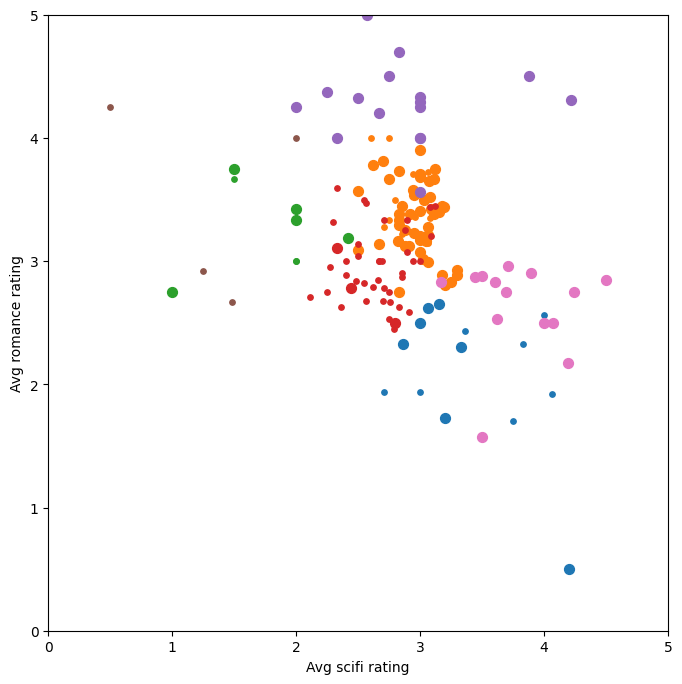

In [14]:
# Turn dataset into a list
X_with_action = biased_dataset_3_genres[['avg_scifi_rating','avg_romance_rating','avg_action_rating']].values# Create an instance of KMeans to find seven clusters
kmeans_5 = KMeans(n_clusters=7)
# Use fit_predict to cluster the dataset
predictions_5 = kmeans_5.fit_predict(X_with_action)
# Define 3d plotting function
def draw_clusters_3d(biased_dataset_3, predictions):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg scifi rating')
    ax.set_ylabel('Avg romance rating')
    clustered = pd.concat([biased_dataset_3.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    colors = itertools.cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])
    for g in clustered.group.unique():
        color = next(colors)
        for index, point in clustered[clustered.group == g].iterrows():
            if point['avg_action_rating'].astype(float) > 3:
                size = 50
            else:
                size = 15
            plt.scatter(point['avg_scifi_rating'],
                        point['avg_romance_rating'],
                        s=size,
                        color=color)# Plot
draw_clusters_3d(biased_dataset_3_genres, predictions_5)

The size of the dots represent the ratings of the action movies.

# Exercise 1

## Instead of choosing a n_clusters as 7, play around with different k
## Find the optimal no of clusters with 3 genre_ratings data we just created using silhouette score method

In [15]:
# CODE

### Taking users into consideration

Once we have seen and understood how the K-Means algorithm group the users by their movie genre preferences, we are going to take a bigger picture of the dataset and explore how users rate individual movies.

To do so, we will subset the dataset by ‘userid’ vs ‘user rating’ as follows.

In [16]:
# Merge the two tables then pivot so we have Users X Movies dataframe
ratings_title = pd.merge(ratings, movies[['movieId', 'title']], on='movieId' )
user_movie_ratings = pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')

# Print he number of dimensions and a subset of the dataset
print('dataset dimensions: ', user_movie_ratings.shape, '\n\nSubset example:')
user_movie_ratings.iloc[:6, :10]

dataset dimensions:  (610, 9719) 

Subset example:


title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987)
userId,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
import pandas as pd

def sort_by_rating_density(user_movie_ratings, n_movies, n_users):
    # Select top n_movies by number of ratings
    most_rated_movies = user_movie_ratings.sum().nlargest(n_movies).index
    filtered_ratings = user_movie_ratings[most_rated_movies]

    # Select top n_users by number of ratings
    most_active_users = filtered_ratings.T.sum().nlargest(n_users).index
    filtered_ratings = filtered_ratings.loc[most_active_users]

    return filtered_ratings

# Example DataFrame
data = {
    "Movie1": [5, 4, None, 2, 1],
    "Movie2": [3, None, 5, 2, 4],
    "Movie3": [None, 2, 3, 5, None],
}
user_movie_ratings = pd.DataFrame(data)

n_movies = 2
n_users = 3

most_rated_movies_users_selection = sort_by_rating_density(user_movie_ratings, n_movies, n_users)

print(most_rated_movies_users_selection)


   Movie2  Movie1
0     3.0     5.0
2     5.0     NaN
4     4.0     1.0


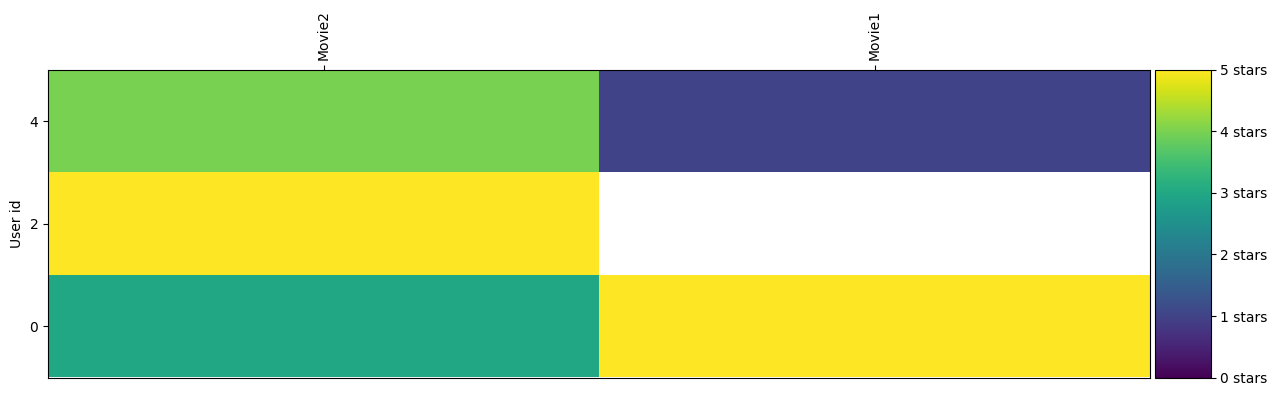

In [19]:
# Define the plotting heatmap function
def draw_movies_heatmap(most_rated_movies_users_selection, axis_labels=True):

    fig = plt.figure(figsize=(15,4))
    ax = plt.gca()

    # Draw heatmap
    heatmap = ax.imshow(most_rated_movies_users_selection,  interpolation='nearest', vmin=0, vmax=5, aspect='auto')
    if axis_labels:
        ax.set_yticks(np.arange(most_rated_movies_users_selection.shape[0]) , minor=False)
        ax.set_xticks(np.arange(most_rated_movies_users_selection.shape[1]) , minor=False)
        ax.invert_yaxis()
        ax.xaxis.tick_top()
        labels = most_rated_movies_users_selection.columns.str[:40]
        ax.set_xticklabels(labels, minor=False)
        ax.set_yticklabels(most_rated_movies_users_selection.index, minor=False)
        plt.setp(ax.get_xticklabels(), rotation=90)
    else:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    ax.grid(False)
    ax.set_ylabel('User id')# Separate heatmap from color bar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)# Color bar
    cbar = fig.colorbar(heatmap, ticks=[5, 4, 3, 2, 1, 0], cax=cax)
    cbar.ax.set_yticklabels(['5 stars', '4 stars','3 stars','2 stars','1 stars','0 stars'])
    plt.show()# Print the heatmap
draw_movies_heatmap(most_rated_movies_users_selection)

In [21]:
import pandas as pd
import numpy as np

# Dummy DataFrame similar to user_movie_ratings
ratings_title = pd.DataFrame({
    'userId': [1, 2, 1, 3, 2, 3, 1, 2, 3],
    'title': ['Movie A', 'Movie B', 'Movie C', 'Movie A', 'Movie C', 'Movie B', 'Movie D', 'Movie A', 'Movie C'],
    'rating': [5, 3, 4, 2, 5, 4, 1, 5, 2]
})

# Create a pivot table
user_movie_ratings = pd.pivot_table(ratings_title, index='userId', columns='title', values='rating')

# Function to get the most rated movies
def get_most_rated_movies(user_movie_ratings, n):
    most_rated = user_movie_ratings.count().nlargest(n).index
    return user_movie_ratings[most_rated]

# Fixing the function call
most_rated_movies_1k = get_most_rated_movies(user_movie_ratings, 3).fillna(0)  # Reduced to 3 for testing

# Display result
print(most_rated_movies_1k)


title   Movie A  Movie C  Movie B
userId                           
1           5.0      4.0      0.0
2           5.0      5.0      3.0
3           2.0      2.0      4.0


In [22]:
from scipy import sparse

# Conversion to sparse csr matrix
sparse_ratings = sparse.csr_matrix(most_rated_movies_1k.values)

### Large Scale Clustering

In [25]:
from sklearn.cluster import KMeans
import pandas as pd

# Ensure we don't have more clusters than samples
n_clusters = min(20, sparse_ratings.shape[0])

# Run KMeans with a valid number of clusters
predictions = KMeans(n_clusters=n_clusters, algorithm='lloyd').fit_predict(sparse_ratings)

# Combining with user_movie_ratings
clustered = pd.concat([get_most_rated_movies(user_movie_ratings, 1000).reset_index(),
                       pd.DataFrame({'group': predictions})], axis=1)

print(clustered.head())


   userId  Movie A  Movie C  Movie B  Movie D  group
0       1      5.0      4.0      NaN      1.0      2
1       2      5.0      5.0      3.0      NaN      0
2       3      2.0      2.0      4.0      NaN      1


### Predictions and Recommendation

In [27]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

# Sample data simulating user ratings for movies
ratings_title = pd.DataFrame({
    'userId': [1, 2, 1, 3, 2, 3, 1, 2, 3],
    'title': ['Movie A', 'Movie B', 'Movie C', 'Movie A', 'Movie C', 'Movie B', 'Movie D', 'Movie A', 'Movie C'],
    'rating': [5, 3, 4, 2, 5, 4, 1, 5, 2]
})

# 1️⃣ **Create User-Movie Ratings Pivot Table**
user_movie_ratings = pd.pivot_table(ratings_title, index='userId', columns='title', values='rating')

# 2️⃣ **Function to Select the Most Rated Movies**
def get_most_rated_movies(user_movie_ratings, n):
    most_rated = user_movie_ratings.count().nlargest(n).index  # Select top 'n' most rated movies
    return user_movie_ratings[most_rated]

# 3️⃣ **Convert to Sparse Matrix for Efficient Clustering**
sparse_ratings = user_movie_ratings.fillna(0).values  # Filling NaN values with 0

# 4️⃣ **Fix: Ensure Number of Clusters Does Not Exceed Available Samples**
n_clusters = min(20, sparse_ratings.shape[0])  # Avoid ValueError

# 5️⃣ **Apply KMeans Clustering**
predictions = KMeans(n_clusters=n_clusters, algorithm='lloyd', random_state=42).fit_predict(sparse_ratings)

# 6️⃣ **Combine Clustering Results with User-Movie Data**
clustered = pd.concat([
    get_most_rated_movies(user_movie_ratings, 1000).reset_index(drop=False),  # Keep index as column
    pd.DataFrame({'group': predictions})
], axis=1)

# 7️⃣ **Fix: Handle Missing Columns Before Dropping**
cluster_number = 0  # Example: Selecting users from cluster 0
columns_to_drop = [col for col in ['index', 'group'] if col in clustered.columns]

cluster = clustered[clustered['group'] == cluster_number].drop(columns=columns_to_drop, axis=1)

# 8️⃣ **Display the Result**
print(cluster.head())


   userId  Movie A  Movie C  Movie B  Movie D
1       2      5.0      5.0      3.0      NaN


In [29]:
import pandas as pd
import difflib

# Sample DataFrame (user_movie_ratings)
data = {
    "The Matrix (1999)": [5, 4, None, 2, 1],
    "Inception (2010)": [3, None, 5, 2, 4],
    "Interstellar (2014)": [None, 2, 3, 5, None],
}
user_movie_ratings = pd.DataFrame(data)

# Movie to search for
movie_name = "Matrix, The (1999)"

# 1️⃣ **Check if movie exists before accessing**
if movie_name in user_movie_ratings.columns:
    matrix_ratings = user_movie_ratings[movie_name]
else:
    # 2️⃣ **Find closest match if movie is missing**
    all_movies = user_movie_ratings.columns.tolist()
    closest_match = difflib.get_close_matches(movie_name, all_movies, n=1)

    if closest_match:
        print(f"Movie '{movie_name}' not found. Did you mean: '{closest_match[0]}'?")
    else:
        print(f"Movie '{movie_name}' not found in the dataset.")


Movie 'Matrix, The (1999)' not found. Did you mean: 'The Matrix (1999)'?


In [30]:
# The average rating of 20 movies as rated by the users in the cluster
cluster.mean().head(20)

,0
userId,2.0
Movie A,5.0
Movie C,5.0
Movie B,3.0
Movie D,NaN


In [31]:
cluster

,userId,Movie A,Movie C,Movie B,Movie D
1,2,5.0,5.0,3.0,NaN


In [33]:
import pandas as pd

# Example DataFrame with a string-based index
data = {"A": [10, 20, 30], "B": [40, 50, 60]}
df = pd.DataFrame(data, index=["1", "2", "3"])

# Trying to access `7` will fail
key = "7"

# Check if key exists before accessing
if key in df.index:
    print(df.loc[key])
else:
    print(f"Key {key} not found!")


Key 7 not found!


## Using Collaborative Filtering (With fast.ai)

In [34]:
! [ -e /content ] && pip install -Uqq fastai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 772.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 29.8 MB/s eta 0:00:00


In [35]:
from fastai.tabular.all import *
from fastai.collab import *

### Training a model

For this, we will use the [Movielens 100k data dataset](https://grouplens.org/datasets/movielens/100k/). We can download it easily and decompress it with the following function:

In [36]:
path = untar_data(URLs.ML_100k)

The main table is in `u.data`. Since it's not a proper csv, we have to specify a few things while opening it: the tab delimiter, the columns we want to keep and their names.

In [37]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      usecols=(0,1,2), names=['user','movie','rating'])
ratings.head()

,user,movie,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


Movie ids are not ideal to look at things, so we load the corresponding movie id to the title that is in the table `u.item`:

In [38]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


Next we merge it to our ratings table:

In [39]:
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,title
0,196,242,3,Kolya (1996)
1,186,302,3,L.A. Confidential (1997)
2,22,377,1,Heavyweights (1994)
3,244,51,2,Legends of the Fall (1994)
4,166,346,1,Jackie Brown (1997)


We can then build a `DataLoaders` object from this table. By default, it takes the first column for user, the second column for the item (here our movies) and the third column for the ratings. We need to change the value of `item_name` in our case, to use the titles instead of the ids:

In [40]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)

In all applications, when the data has been assembled in a `DataLoaders`, you can have a look at it with the `show_batch` method:

In [41]:
dls.show_batch()

,user,title,rating
0,121,"Juror, The (1996)",5
1,64,This Is Spinal Tap (1984),5
2,77,Brazil (1985),4
3,346,Showgirls (1995),1
4,183,"Professional, The (1994)",4
5,564,"Devil's Own, The (1997)",4
6,856,Liar Liar (1997),4
7,875,Raise the Red Lantern (1991),5
8,618,Murder in the First (1995),2
9,903,"Game, The (1997)",4


fastai can create and train a collaborative filtering model by using `collab_learner`:

In [42]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

It uses a simple dot product model with 50 latent factors. To train it using the 1cycle policy, we just run this command:

In [43]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.892106,0.953939,00:09
1,0.672891,0.899141,00:08
2,0.532450,0.879617,00:07
3,0.456709,0.860975,00:08
4,0.437088,0.856239,00:09


Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on RMSE of 0.91 (scroll down to the 100k dataset), which corresponds to an MSE of `0.91**2 = 0.83`. So in less than a minute, we got pretty good results!

### Interpretation

Let's analyze the results of our previous model. We will keep the 1000 most rated movies for this:

In [44]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)',
       'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)',
       'Air Force One (1997)', 'Independence Day (ID4) (1996)'],
      dtype=object)

### Movie bias

Our model has learned one bias per movie, a unique number independent of users that can be interpreted as the intrinsic "value" of the movie. We can grab the bias of each movie in our `top_movies` list with the following command:

In [45]:
movie_bias = learn.model.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

Let's compare those biases with the average ratings:

In [46]:
mean_ratings = ratings.groupby('title')['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

Now let's have a look at the movies with the worst bias:

In [47]:
item0 = lambda o:o[0]
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.3346),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.2954),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.2944), 'Leave It to Beaver (1997)', 1.8409090909090908),
 (tensor(-0.2897), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.2833), 'Grease 2 (1982)', 2.0),
 (tensor(-0.2709), 'Spice World (1997)', 2.1153846153846154),
 (tensor(-0.2699), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.2546), 'Halloween: The Curse of Michael Myers (1995)', 2.2),
 (tensor(-0.2402), 'Free Willy (1993)', 2.4545454545454546),
 (tensor(-0.2398), 'Island of Dr. Moreau, The (1996)', 2.1578947368421053),
 (tensor(-0.2369), "Stephen King's The Langoliers (1995)", 2.413793103448276),
 (tensor(-0.2355), "Joe's Apartment (1996)", 2.2444444444444445),
 (tensor(-0.2293), 'Two if by Sea (1996)', 2.6),
 (tensor(-0.2291), 'Escape from L.A. (1996)', 2.4615384615384617),
 (tensor(-0.2155), 'Thinner (1996

Or the ones with the best bias:

In [48]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.5832), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.5622), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.5611), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.5269), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.5225), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.5110), "One Flew Over the Cuckoo's Nest (1975)", 4.291666666666667),
 (tensor(0.4956), 'Boot, Das (1981)', 4.203980099502488),
 (tensor(0.4756), 'Wrong Trousers, The (1993)', 4.466101694915254),
 (tensor(0.4747), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.4653), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.4609), 'Usual Suspects, The (1995)', 4.385767790262173),
 (tensor(0.4507), 'Close Shave, A (1995)', 4.491071428571429),
 (tensor(0.4488), 'North by Northwest (1959)', 4.284916201117318),
 (tensor(0.4416), 'To Kill a Mockingbird (1962)', 4.292237442922374),
 (tensor(0.4396), 'Casablanca (1942)', 4.45679012345679)]

There is certainly a strong correlation!

### Movie weights

Now let's try to analyze the latent factors our model has learned. We can grab the weights for each movie in `top_movies` the same way as we did for the bias before.

In [49]:
movie_w = learn.model.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 50])

Let's try a PCA to reduce the dimensions and see if we can see what the model learned:

In [50]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [51]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

Here are the highest score on the first dimension:

In [52]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.2012), 'Casablanca (1942)'),
 (tensor(1.1996), 'Close Shave, A (1995)'),
 (tensor(1.1861), 'Wrong Trousers, The (1993)'),
 (tensor(1.1318), 'Lawrence of Arabia (1962)'),
 (tensor(1.0403), 'Godfather, The (1972)'),
 (tensor(0.9950), 'Chinatown (1974)'),
 (tensor(0.9783), 'Citizen Kane (1941)'),
 (tensor(0.9705), 'Persuasion (1995)'),
 (tensor(0.9528), 'Fargo (1996)'),
 (tensor(0.9283),
  'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)')]

And the worst:

In [53]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.2864), 'Jungle2Jungle (1997)'),
 (tensor(-1.1236), 'Cutthroat Island (1995)'),
 (tensor(-1.1148), 'Free Willy 3: The Rescue (1997)'),
 (tensor(-1.0984), 'Children of the Corn: The Gathering (1996)'),
 (tensor(-1.0887), 'Bio-Dome (1996)'),
 (tensor(-1.0813), 'Batman Forever (1995)'),
 (tensor(-1.0680), 'Home Alone 3 (1997)'),
 (tensor(-1.0509), 'Crow: City of Angels, The (1996)'),
 (tensor(-1.0353), 'Jaws 3-D (1983)'),
 (tensor(-1.0235), 'That Darn Cat! (1997)')]

Same thing for our second dimension:

In [54]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [55]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.2287), 'Titanic (1997)'),
 (tensor(1.0594), 'Braveheart (1995)'),
 (tensor(1.0025), 'Raiders of the Lost Ark (1981)'),
 (tensor(0.9689), 'Air Force One (1997)'),
 (tensor(0.9004), 'True Lies (1994)'),
 (tensor(0.8963), 'Forrest Gump (1994)'),
 (tensor(0.8579), 'Dances with Wolves (1990)'),
 (tensor(0.8379), 'Shawshank Redemption, The (1994)'),
 (tensor(0.8313), 'Independence Day (ID4) (1996)'),
 (tensor(0.8251), 'Jurassic Park (1993)')]

In [56]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-0.8900), 'Ready to Wear (Pret-A-Porter) (1994)'),
 (tensor(-0.8878), 'To Die For (1995)'),
 (tensor(-0.8871), 'Dracula: Dead and Loving It (1995)'),
 (tensor(-0.8272), 'Jingle All the Way (1996)'),
 (tensor(-0.8249), 'Cable Guy, The (1996)'),
 (tensor(-0.8081), 'Very Brady Sequel, A (1996)'),
 (tensor(-0.8032), 'Jude (1996)'),
 (tensor(-0.8003), 'Clockwork Orange, A (1971)'),
 (tensor(-0.7863), 'Brazil (1985)'),
 (tensor(-0.7664), 'Serial Mom (1994)')]

And we can even plot the movies according to their scores on those dimensions:

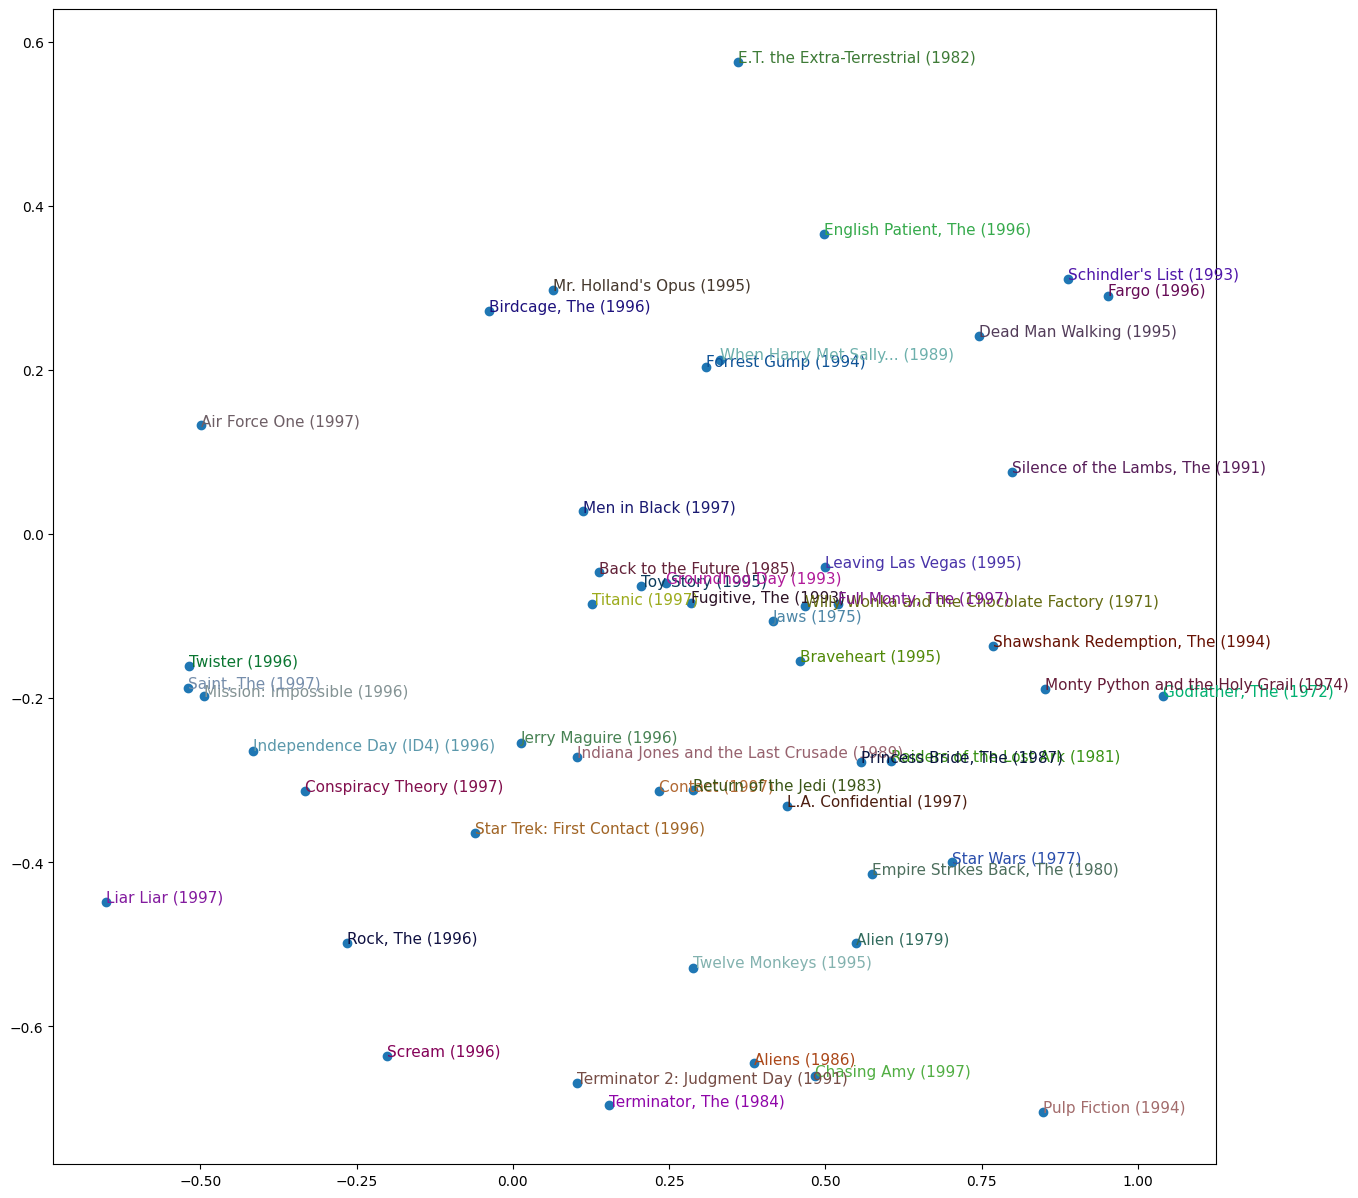

In [57]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

# Exercise 2

## Play around with different collaborative filtering model parameters such as n_factors and other parameters.
## Identify if any such parameters have impact on the speed of convergence or the performance on the model

In [ ]:
# CODE